## Load Data

Used libraries:

numpy==1.14.2

pandas==0.23.4

catboost==0.9.1.1

xgboost==0.72

lightgbm==2.0.6


In [43]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from catboost import CatBoostRegressor
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error 
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import pickle


print(os.listdir("../input"))

items_df = pd.read_csv('../input/items.csv')
shops_df = pd.read_csv('../input/shops.csv')

icats_df = pd.read_csv('../input/item_categories.csv')
train_df = pd.read_csv('../input/sales_train.csv.gz', compression='gzip', header=0, sep=',', quotechar='"')
smpsb_df = pd.read_csv('../input/sample_submission.csv.gz', compression='gzip', header=0, sep=',', quotechar='"')
test_df  = pd.read_csv('../input/test.csv.gz', compression='gzip', header=0, sep=',', quotechar='"')


['items.csv', 'item_categories.csv', 'sales_train.csv.gz', 'sample_submission.csv.gz', 'shops.csv', 'test.csv.gz']


## Map Items Categorries
Map Categories to more narrow ones

In [2]:
l = list(icats_df.item_category_name)
l_cat = l

for ind in range(1,8):
    l_cat[ind] = 'Access'

for ind in range(10,18):
    l_cat[ind] = 'Consoles'

for ind in range(18,25):
    l_cat[ind] = 'Consoles Games'

for ind in range(26,28):
    l_cat[ind] = 'phone games'

for ind in range(28,32):
    l_cat[ind] = 'CD games'

for ind in range(32,37):
    l_cat[ind] = 'Card'

for ind in range(37,43):
    l_cat[ind] = 'Movie'

for ind in range(43,55):
    l_cat[ind] = 'Books'

for ind in range(55,61):
    l_cat[ind] = 'Music'

for ind in range(61,73):
    l_cat[ind] = 'Gifts'

for ind in range(73,79):
    l_cat[ind] = 'Soft'


icats_df['cats'] = l_cat
icats_df.head()

## Pre-Train

In [3]:
train_df['date'] = pd.to_datetime(train_df.date,format="%d.%m.%Y")
train_df['month'] = train_df['date_block_num']%12
train_df.head()


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month
0,2013-01-02,0,59,22154,999.00,1.0,0
1,2013-01-03,0,25,2552,899.00,1.0,0
2,2013-01-05,0,25,2552,899.00,-1.0,0
3,2013-01-06,0,25,2554,1709.05,1.0,0
4,2013-01-15,0,25,2555,1099.00,1.0,0


In [5]:

shops_df.loc[shops_df.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops_df['city'] = shops_df['shop_name'].str.split(' ').map(lambda x: x[0])
shops_df.loc[shops_df.city == '!Якутск', 'city'] = 'Якутск'
shops_df['city_code'] = LabelEncoder().fit_transform(shops_df['city'])
shops_df = shops_df[['shop_id','city_code']]


In [6]:
shops_df.head()

,shop_id,city_code
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2
5,5,3
6,6,4
7,7,4
8,8,4
9,9,5


# Join training tables together

In [7]:
joined = pd.merge(train_df, items_df, left_on='item_id', right_on='item_id')
joined = pd.merge(joined, icats_df, left_on='item_category_id', right_on='item_category_id')

# Cast and split train data date

In [8]:
joined['date'] = pd.to_datetime(joined['date'], format="%d.%m.%Y")
joined['year'] = joined['date'].dt.year
joined['month'] = joined['date'].dt.month
joined['day'] = joined['date'].dt.day
joined['dayofweek'] = joined['date'].dt.dayofweek # The day of the week with Monday=0, Sunday=6

# EDA

In [9]:

data = joined.groupby(["date"]).agg({"year": "count"})
data['2013-12-20':'2014-01-01']

,year
date,
2013-12-20,4321
2013-12-21,6773
2013-12-22,6070
2013-12-23,3959
2013-12-24,4177
2013-12-25,5223
2013-12-26,5598
2013-12-27,6211
2013-12-28,9434


## Check seasonality for each categories

In [10]:
import matplotlib.pyplot as plt

allCats = joined['cats'].unique()

print(allCats)
for cat in allCats:
    data = joined.loc[joined['cats'] == cat].groupby(["date"]).agg({"year": "count"})
    res = data.copy()
    res['rolling30'] = data.copy().rolling(30).mean()
    res['rolling120'] = data.copy().rolling(120).mean()
    res['rolling365'] = data.copy().rolling(365).mean()
    res.plot(kind="line", figsize=(15,6), stacked=False, title=cat)
    


['Movie' 'Music' 'Consoles Games' 'CD games' 'Soft' 'Books' 'Gifts'
 'Access' 'Consoles' 'Card' 'Игры - Аксессуары для игр'
 'Чистые носители (штучные)' 'Чистые носители (шпиль)' 'Служебные'
 'PC - Гарнитуры/Наушники' 'Элементы питания' 'Доставка товара'
 'Билеты (Цифра)' 'phone games' 'Служебные - Билеты']


On the plots we can clearly see a peak around new year. Let`s check the other holidays.

## Holidays in russia

Set a holiday column for additional information

In [11]:
#https://www.officeholidays.com/countries/russia/2013.php
russian_holidays_13 = ['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04', '2013-01-07', '2013-01-08', '2013-02-23',
                   '2013-03-08', '2013-05-01', '2013-05-02', '2013-05-03', '2013-05-09', '2013-05-10', '2013-06-12',
                   '2013-11-04','2013-12-24','2013-12-25','2013-12-26']
russian_holidays_14 = ['2014-01-01', '2014-01-02', '2014-01-03', '2014-01-06', '2014-01-07', '2014-01-08', '2014-02-23',
                   '2014-03-10', '2014-05-01', '2014-05-02', '2014-05-09', '2014-06-12', '2014-06-13', '2014-11-04',
                   '2014-11-04','2014-12-24','2014-12-25','2014-12-26']
russian_holidays_15 = ['2015-01-01', '2015-01-02', '2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08', '2015-02-23',
                   '2015-03-09', '2015-05-01', '2015-05-04', '2015-05-09', '2015-05-11', '2015-06-12', '2015-11-04',
                   '2015-11-29','2015-12-24','2015-12-25','2015-12-26']

allHolidays = russian_holidays_13 + russian_holidays_14 + russian_holidays_15


joined['holiday'] = joined['date'].isin(allHolidays)
joined = joined.set_index('date')

## Daily distribution + holiday

Usually it`s a common sense that the number of shoppers are changing close to holiday.
Let`s check the end of the year:

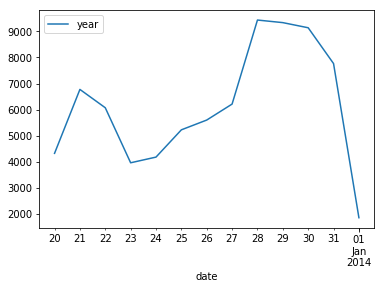

In [12]:
data = joined.groupby(["date"]).agg({"year": "count"})
data['2013-12-20':'2014-01-01']
data['2013-12-20':'2014-01-01'].plot()

We can see that during the holiday the weekdays are much more popular:

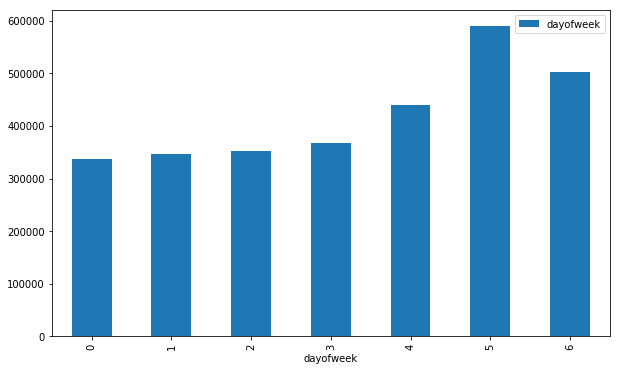

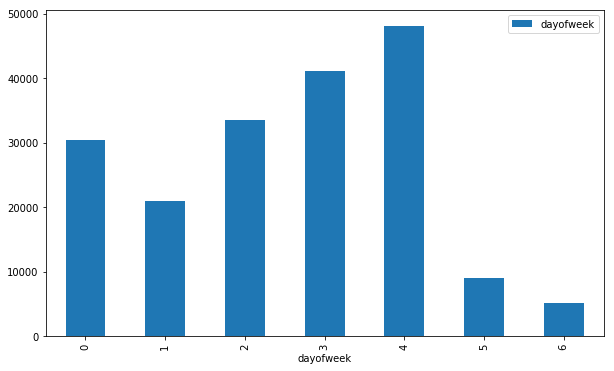

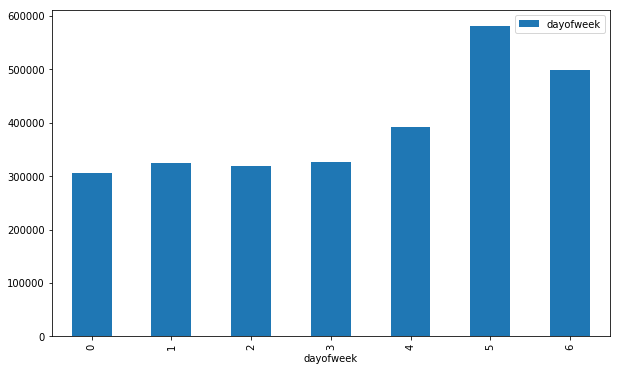

In [13]:

joined.groupby("dayofweek").agg({"dayofweek": "count"}).plot.bar(figsize=(10, 6))
joined[joined['holiday']==True].groupby("dayofweek").agg({"dayofweek": "count"}).plot.bar(figsize=(10, 6))
joined[joined['holiday']==False].groupby("dayofweek").agg({"dayofweek": "count"}).plot.bar(figsize=(10, 6))

## Distribution per shop:

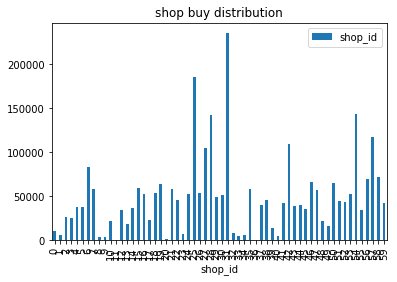

In [14]:
data = joined.groupby(["shop_id"]).agg({"shop_id": "count"})
data.plot(kind="bar", title="shop buy distribution")

# Preprocessing

In [15]:
## Pivot by month to wide format
p_df = train_df.pivot_table(index=['shop_id','item_id'], columns='date_block_num', values='item_cnt_day',aggfunc='sum').fillna(0.0)
p_df.head()

date_block_num    0     1    2    3    4    5    6    7    8    9  ...    24  \
shop_id item_id                                                    ...         
0       30       0.0  31.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
        31       0.0  11.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
        32       6.0  10.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
        33       3.0   3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
        35       1.0  14.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   

date_block_num    25   26   27   28   29   30   31   32   33  
shop_id item_id                                               
0       30       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        31       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        32       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        33       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        35       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 34 columns]

In [16]:
## Join with categories
train_cleaned_df = p_df.reset_index()
train_cleaned_df = train_cleaned_df.merge(shops_df, how="inner", on="shop_id")

train_cleaned_df['shop_id']= train_cleaned_df.shop_id.astype('str')
train_cleaned_df['item_id']= train_cleaned_df.item_id.astype('str')
train_cleaned_df['city_code']= train_cleaned_df.city_code.astype('str')

item_to_cat_df = items_df.merge(icats_df[['item_category_id','cats']], how="outer", on="item_category_id")[['item_id','cats']]
item_to_cat_df[['item_id']] = item_to_cat_df.item_id.astype('str')

train_cleaned_df = train_cleaned_df.merge(item_to_cat_df, how="outer", on="item_id")

train_cleaned_df = train_cleaned_df.fillna(0)

# Encode Categories


number = preprocessing.LabelEncoder()
train_cleaned_df[['cats']] = number.fit_transform(train_cleaned_df.cats)
train_cleaned_df = train_cleaned_df[['shop_id', 'item_id', 'cats', 'city_code'] + list(range(34))]
#train_cleaned_df = train_cleaned_df[['shop_id', 'item_id', 'cats', 'city_code'] + list(range(11,34))]
train_cleaned_df.head()


,shop_id,item_id,cats,city_code,0,1,2,3,4,5,...,24,25,26,27,28,29,30,31,32,33
0,0,30,7,29,0.0,31.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,30,7,29,0.0,10.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,30,7,0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,30,7,1,0.0,4.0,5.0,2.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,4,30,7,2,0.0,7.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
df3 = (train_cleaned_df[['shop_id','item_id', 'cats', 30,31,32]]
       .set_index(['shop_id','item_id', 'cats'])
       .rolling(3, axis=1).mean()
       .dropna(axis=1, how='all'))

df3.columns = ['Roll_3_{}'.format(x) for x in range(1, len(df3.columns)+1)]

df6 = (train_cleaned_df[['shop_id','item_id', 'cats', 27,28,29,30,31,32]].set_index(['shop_id','item_id', 'cats'])
       .rolling(6, axis=1).mean()
       .dropna(axis=1, how='all'))

df6.columns = ['Roll_6_{}'.format(x) for x in range(1, len(df6.columns)+1)]

df12= (train_cleaned_df[['shop_id','item_id', 'cats', 21,22,23,24,25,26,27,28,29,30,31,32]].set_index(['shop_id','item_id', 'cats'])
       .rolling(12, axis=1).mean()
       .dropna(axis=1, how='all'))

df12.columns = ['Roll_12_{}'.format(x) for x in range(1, len(df12.columns)+1)]

train_cleaned_df = train_cleaned_df.join(df3, on=['shop_id','item_id', 'cats'])
train_cleaned_df = train_cleaned_df.join(df6, on=['shop_id','item_id', 'cats'])
train_cleaned_df = train_cleaned_df.join(df12, on=['shop_id','item_id', 'cats'])

In [18]:
train_cleaned_df['maxValue'] = train_cleaned_df.max(axis=1)

In [19]:
def meanEncodeTarget(all_data):
    col = 'item_id'
    for target in range(0,33):
        cumsum = all_data.groupby(col)[target].cumsum() - all_data[target]
        cumcnt = all_data.groupby(col).cumcount()
        all_data['item_target_enc' + str(target)] = cumsum/cumcnt
        num_fillna = 0.3343 #/ 34
        all_data['item_target_enc' + str(target)].fillna(num_fillna, inplace = True)
    return all_data




In [20]:
train_cleaned_df = meanEncodeTarget(train_cleaned_df)

In [21]:
train_cleaned_df['city_code'].unique().shape

(32,)

## Modelling

In [49]:

def printScore(modelName, y_test, preds):
    print('Test rmse for %s is %f' % (modelName, np.sqrt(mean_squared_error(y_test, preds))))
    print('Test R-squared for %s is %f' % (modelName, r2_score(y_test, preds)))

In [62]:

def loadModelIfExist(filename):
    return pickle.load(open(filename, 'rb'))
                       
def trainLinearRegression(X_train, Y_train):
    if os.path.exists('lr.sav'):
        lr = loadModelIfExist('lr.sav')  
    else:
        lr = LinearRegression()
        lr.fit(X_train.values, Y_train)
    return lr
    
def trainXGBoost(X_train, Y_train):
    param = {'max_depth':5,
             'n_jobs': 4,
             'subsample':1,
             'min_child_weight':300,
             'n_estimators':100,
             'eta':0.2, 
             'num_round':5000, 
             'seed':1,
             'silent':0,
             'eval_metric':'rmse'}
    
    param2= {'max_depth':8, 
             'n_estimators':1000,
            'subsample':0.8,
             'colsample_bytree':0.8,
             'min_child_weight':300,
            'eta':0.3, 
            'seed':42,
            'eval_metric':'rmse'}

    progress = dict()
    xgbtrain = xgb.DMatrix(X_train.values, Y_train.values)
    watchlist  = [(xgbtrain,'train-rmse')]
    if os.path.exists('bst.sav'):
        bst = loadModelIfExist('bst.sav')  
    else:
        bst = xgb.train(param, xgbtrain)
    return bst

def trainRandomForest(X_train, Y_train):
    regr = RandomForestRegressor(max_depth=5, random_state=0, n_estimators = 100)
    if os.path.exists('regr.sav'):
        regr = loadModelIfExist('regr.sav')  
    else:
        regr.fit(X_train, Y_train)
    return regr

def trainlightGBM(X_train, Y_train):
    lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':4, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.05, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

    X_train_int = X_train.copy()
    X_train_int['shop_id'] = X_train_int.shop_id.astype('int')
    X_train_int['item_id'] = X_train_int.item_id.astype('int')
    X_train_int['city_code'] = X_train_int.item_id.astype('int')


    y = Y_train.values.ravel()
    if os.path.exists('gbm.sav'):
        gbm = loadModelIfExist('gbm.sav')  
    else:
        gbm = lgb.train(lgb_params, lgb.Dataset(X_train_int, label=y), 100)
    return gbm
    

In [52]:
X_train = train_cleaned_df.drop(columns=[33], axis = 1)
Y_train = train_cleaned_df.iloc[:, train_cleaned_df.columns == 33]


X_test = train_cleaned_df.drop(columns=[33], axis = 1)
Y_test = train_cleaned_df.iloc[:, train_cleaned_df.columns == 33]
                                
                                

In [54]:


catboost = CatBoostRegressor(iterations=500, learning_rate=0.5, depth=9, verbose=False)
        # Fit model
if os.path.exists('catboost.sav'):
    catboost = loadModelIfExist('catboost.sav')  
else:
    catboost = catboost.fit(X_train, Y_train, [0,1,2])
        # Get predictions
preds = catboost.predict(X_test.values)
pred_train = catboost.predict(X_train.values)


printScore('catboost', Y_train, pred_train)
printScore('catboost', Y_test, preds)


Test rmse for catboost is 0.422532
Test R-squared for catboost is 0.988868
Test rmse for catboost is 0.422532
Test R-squared for catboost is 0.988868


In [55]:
lr = trainLinearRegression(X_train, Y_train)
preds = lr.predict(X_test.values)
pred_train = lr.predict(X_test.values)
printScore('linreg', Y_train, pred_train)
printScore('linreg', Y_test, preds)

Test rmse for linreg is 2.788820
Test R-squared for linreg is 0.515055
Test rmse for linreg is 2.788820
Test R-squared for linreg is 0.515055


In [56]:
bst =trainXGBoost(X_train, Y_train)
preds = bst.predict(xgb.DMatrix(X_test.values))
pred_train= bst.predict(xgb.DMatrix(X_train.values))
printScore('XGBoostTrain', Y_train, pred_train)
printScore('XGBoost', Y_test, preds)


Test rmse for XGBoostTrain is 3.846592
Test R-squared for XGBoostTrain is 0.077420
Test rmse for XGBoost is 3.846592
Test R-squared for XGBoost is 0.077420


In [57]:
regr = trainRandomForest(X_train,Y_train)
pred_train = regr.predict(X_train)
pred_test = regr.predict(X_test)

printScore('RandomforestTrain', Y_train, pred_train)
printScore('Randomforest', Y_test, pred_test)




Test rmse for RandomforestTrain is 1.733809
Test R-squared for RandomforestTrain is 0.812563
Test rmse for Randomforest is 1.733809
Test R-squared for Randomforest is 0.812563


In [63]:

model = trainlightGBM(X_train, Y_train)

X_test_int = X_test.copy()
X_test_int['shop_id'] = X_test_int.shop_id.astype('int')
X_test_int['item_id'] = X_test_int.item_id.astype('int')
X_test_int['city_code'] = X_test_int.city_code.astype('int')

X_train_int = X_train.copy()
X_train_int['shop_id'] = X_train_int.shop_id.astype('int')
X_train_int['item_id'] = X_train_int.item_id.astype('int')
X_train_int['city_code'] = X_train_int.city_code.astype('int')

pred_lgb = model.predict(X_test_int)
pred_train = model.predict(X_train_int)



printScore('lgbTrain', Y_train, pred_train)
printScore('lgbTest', Y_test, pred_lgb)

Test rmse for lgbTrain is 3.667155
Test R-squared for lgbTrain is 0.161486
Test rmse for lgbTest is 3.667155
Test R-squared for lgbTest is 0.161486


## Ensembling

In [64]:
def ensembleValues(X_train):
    preds_lr_train = lr.predict(X_train.values)
    preds_xg_train  = bst.predict(xgb.DMatrix(X_train.values))
    
    
    preds_rf_train  = regr.predict(X_train)
    
    X_train_int = X_train.copy()
    X_train_int['shop_id'] = X_train_int.shop_id.astype('int')
    X_train_int['item_id'] = X_train_int.item_id.astype('int')
    X_train_int['city_code'] = X_train_int.city_code.astype('int')
    preds_lgb_train  = model.predict(X_train_int)
    
    #pred_catboost = catboost.predict(X_train.values)
    
    print(preds_lr_train.shape)
    print(preds_xg_train.shape)
    print(preds_rf_train.shape)
    print(preds_lgb_train.shape)

    X_train_level2 = pd.DataFrame(data=[])
    
    X_train_level2['xg'] = preds_xg_train.ravel()
    X_train_level2['rf'] = preds_rf_train.ravel()
    
    #X_train_level2['lr'] = pd.Series(preds_lr_train.ravel())
    #X_train_level2['lgb'] = preds_lgb_train.ravel()
    #X_train_level2['cat'] = pred_catboost.ravel()
    return X_train_level2

In [65]:
import gc
gc.collect()

1080

In [66]:

X_train_level2 = ensembleValues(X_train)
X_test_level2= ensembleValues(X_test)


(424487, 1)
(424487,)
(424487,)
(424487,)
(424487, 1)
(424487,)
(424487,)
(424487,)


In [67]:

lr2 = LinearRegression()
if os.path.exists('lr2.sav'):
    lr2 = loadModelIfExist('lr2.sav')  
else:
    lr2 = LinearRegression()
    lr2.fit(X_train_level2, Y_train)
pred_train = lr2.predict(X_train_level2.values)
preds_lvl2 = lr2.predict(X_test_level2.values)


printScore('linreg', Y_train, pred_train)
printScore('linreg', Y_test, preds_lvl2)

print(lr2.coef_)

Test rmse for linreg is 1.330792
Test R-squared for linreg is 0.889574
Test rmse for linreg is 1.330792
Test R-squared for linreg is 0.889574
[[-0.19851981  1.43179433]]


In [68]:
X_train['city_code'].unique().shape

(32,)

## Save models

In [69]:
pickle.dump(lr, open("lr.sav", 'wb'))
pickle.dump(catboost, open("catboost.sav", 'wb'))
pickle.dump(bst, open("bst.sav", 'wb'))
pickle.dump(regr, open("regr.sav", 'wb'))
pickle.dump(model, open("gbm.sav", 'wb'))
pickle.dump(lr2, open("lr2.sav", 'wb'))

## Apply Model

In [70]:
apply_df = test_df
apply_df['shop_id']= apply_df.shop_id.astype('str')
apply_df['item_id']= apply_df.item_id.astype('str')

apply_df = test_df.merge(train_cleaned_df, how = "left", on = ["shop_id", "item_id"]).fillna(0.0)
apply_df.head()

,ID,shop_id,item_id,cats,city_code,0,1,2,3,4,...,item_target_enc23,item_target_enc24,item_target_enc25,item_target_enc26,item_target_enc27,item_target_enc28,item_target_enc29,item_target_enc30,item_target_enc31,item_target_enc32
0,0,5,5037,5.0,3,0.0,0.0,0.0,0.0,0.0,...,3.333333,1.0,0.333333,0.666667,0.0,0.333333,1.000000,0.666667,1.333333,0.333333
1,1,5,5320,0.0,0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,5,5233,5.0,3,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,1.666667,1.666667,1.333333,2.333333,3.000000
3,3,5,5232,5.0,3,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,2.000000,1.000000
4,4,5,5268,0.0,0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000


In [71]:
# Move to one month front
#d = dict(zip(apply_df.columns[5:39],list(np.array(list(apply_df.columns[5:39])) - 1)))
d = dict(zip(apply_df.columns[5:28],list(np.array(list(apply_df.columns[5:28])) - 1)))

apply_df  = apply_df.rename(d, axis = 1)

In [72]:
apply_df.head()

,ID,shop_id,item_id,cats,city_code,-1,0,1,2,3,...,item_target_enc23,item_target_enc24,item_target_enc25,item_target_enc26,item_target_enc27,item_target_enc28,item_target_enc29,item_target_enc30,item_target_enc31,item_target_enc32
0,0,5,5037,5.0,3,0.0,0.0,0.0,0.0,0.0,...,3.333333,1.0,0.333333,0.666667,0.0,0.333333,1.000000,0.666667,1.333333,0.333333
1,1,5,5320,0.0,0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,5,5233,5.0,3,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,1.666667,1.666667,1.333333,2.333333,3.000000
3,3,5,5232,5.0,3,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,2.000000,1.000000
4,4,5,5268,0.0,0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
#X_final_test = apply_df.iloc[:, (apply_df.columns != 'ID') & (apply_df.columns != -1)]
X_final_test = apply_df.iloc[:, (apply_df.columns != 'ID') & (apply_df.columns != 10)]

In [ ]:

preds = lr2.predict(ensembleValues(X_final_test)).ravel()
preds.shape

In [ ]:
#preds = model.predict(apply_df.iloc[:, (apply_df.columns != 'ID') & (apply_df.columns != -1)].values)

In [ ]:
# Normalize prediction to [0-20]
preds = list(map(lambda x: min(20,max(x,0)), list(preds)))
sub_df = pd.DataFrame({'ID':apply_df.ID,'item_cnt_month': preds })
sub_df.describe()

In [ ]:
sub_df.to_csv('ensemble_15.csv',index=False)